In [55]:
import numpy as np
import pandas as pd

df = pd.read_csv('../data/semi_cleaned_data.csv')
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
0,Mumbai,2010,72000,CNG,Manual,First,11.438,998.0,58.16,5.0,1.75,Maruti,Wagon
1,Pune,2015,41000,Diesel,Manual,First,19.670,1582.0,126.20,5.0,12.50,Hyundai,Creta
2,Chennai,2011,46000,Petrol,Manual,First,18.200,1199.0,88.70,5.0,4.50,Honda,Jazz
3,Chennai,2012,87000,Diesel,Manual,First,20.770,1248.0,88.76,7.0,6.00,Maruti,Ertiga
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.200,1968.0,140.80,5.0,17.74,Audi,A4


In [56]:
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,6015.000000,6015.000000,6013.000000,5979.000000,5873.000000,5973.000000,6015.000000
mean,2013.357606,57670.791521,17.989580,1619.954842,113.128200,5.280261,9.425423
std,3.269967,37870.190126,4.554461,598.895895,53.507006,0.805087,10.905359
min,1998.000000,171.000000,0.000000,72.000000,34.200000,2.000000,0.440000
25%,2011.000000,34000.000000,15.100000,1198.000000,75.000000,5.000000,3.500000
50%,2014.000000,53000.000000,18.000000,1493.000000,97.700000,5.000000,5.630000
75%,2016.000000,73000.000000,20.920000,1984.000000,138.100000,5.000000,9.950000
max,2019.000000,775000.000000,28.400000,5998.000000,552.000000,10.000000,100.000000


In [57]:
df.isna().sum()

Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                142
Seats                 42
Price                  0
Brand                  0
Model                  0
dtype: int64

<Axes: >

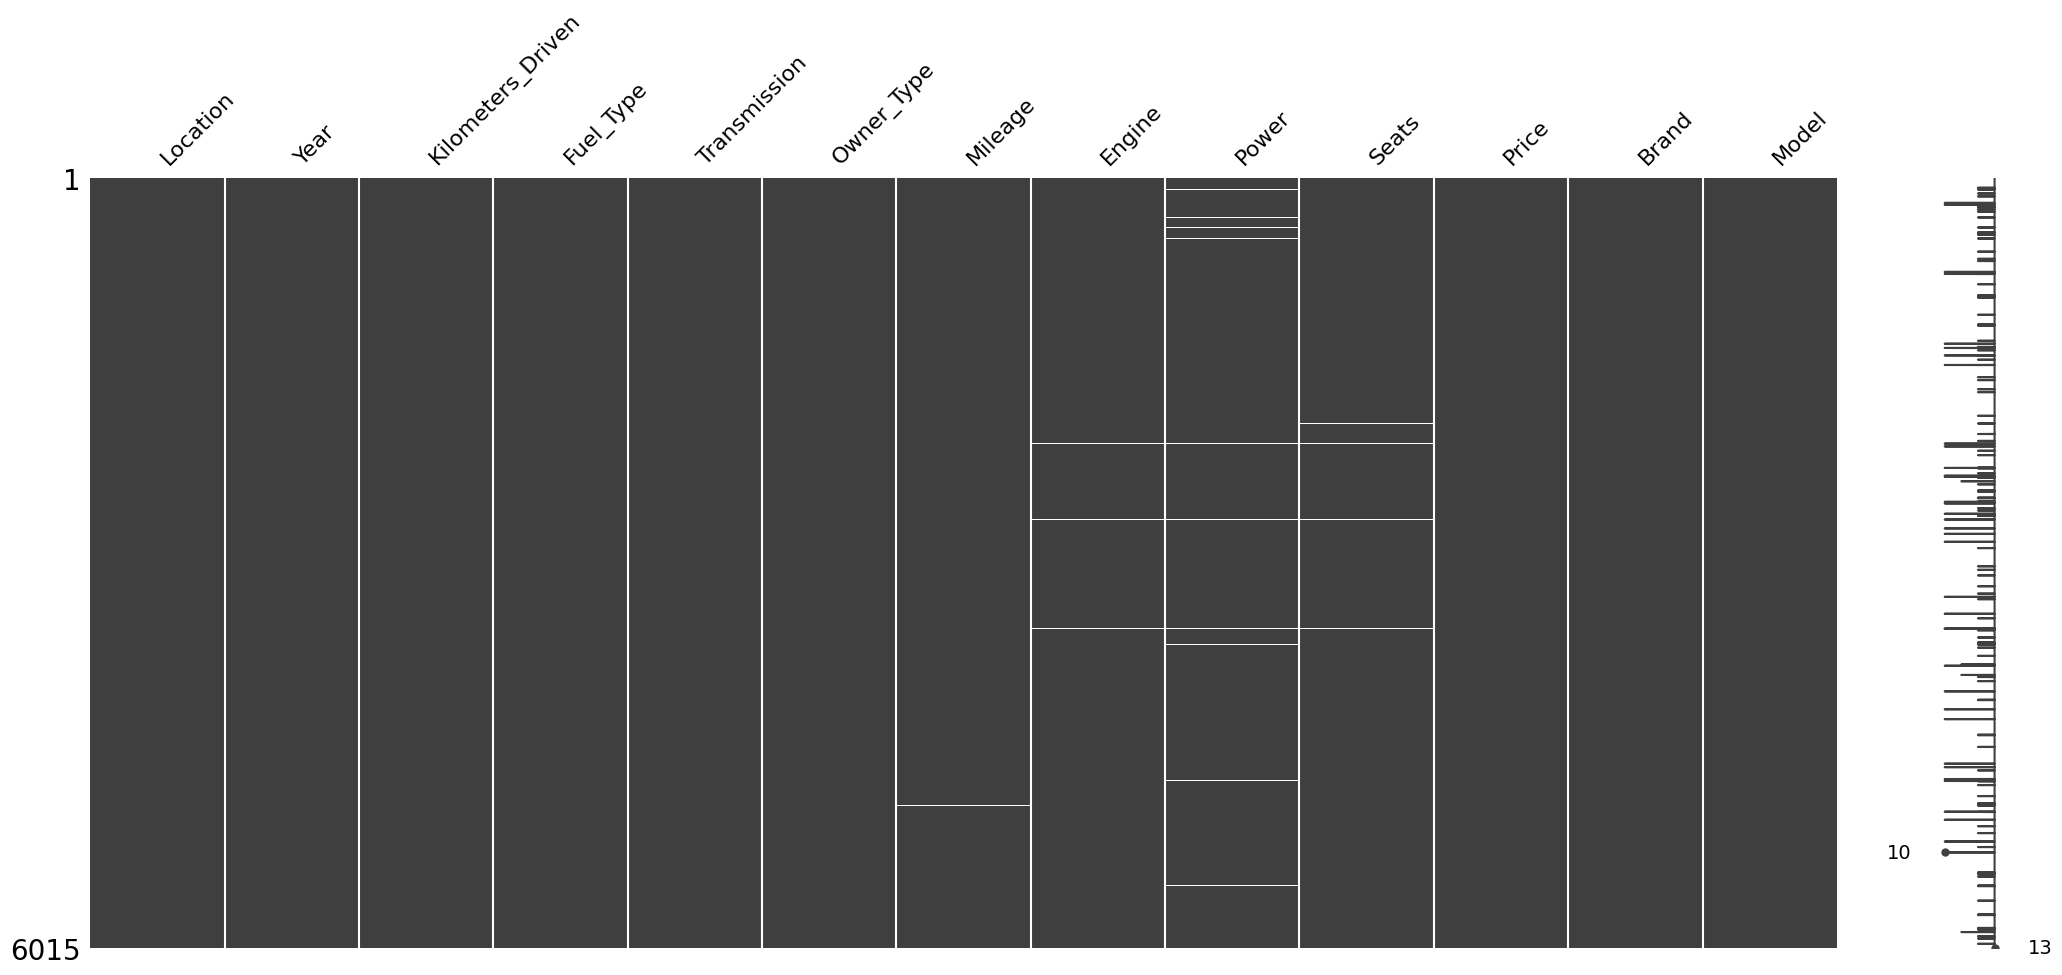

In [58]:
import missingno as msno

msno.matrix(df)

# Data Splitting

👉 We need to handle :
* Missing Values.
* Outliers.
* Categorical.

In [59]:
# Data Splitting

X = df.drop(columns=['Price']).copy()
y = df['Price'].copy()

In [60]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
X_train.shape

(4812, 12)

In [62]:
# Splitting Columns

num_cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Age']  
nom_cat_cols = ['Location', 'Fuel_Type', 'Transmission', 'Brand', 'Model']  # USE Binary ENCODING
ord_cat_cols = ['Owner_Type']   # USE ORDINAL ENCODING

* `Brand` and `Model` are nominal categorical features with high cardinality.  
   binary encoding
* `Location` is a nominal categorical feature with medium cardinality.
   binary encoding
* `Transmission` is a binary categorical feature.
    one-hot encoding (take care of drop first)
* `Fuel_Type` is a nominal categorical feature with some rare categories.
    one-hot encoding (take care of rare categories)
* `Owner_Type` is an ordinal categorical feature.
   ordinal encoder

# Data Preprocessing & Base Model

In [63]:
# ==== IMPORTS ====
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from category_encoders import BinaryEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [64]:
# Very Simple Preprocessing & Base Model
num_cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats']  
nom_cat_cols = ['Location', 'Fuel_Type', 'Transmission', 'Brand', 'Model']
ord_cat_cols = ['Owner_Type']

imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler()
bin_enc = BinaryEncoder()
ord_enc = OrdinalEncoder(categories=[['Fourth & Above', 'Third', 'Second', 'First']],
                         handle_unknown="use_encoded_value", unknown_value=-1)

log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one" )  

num_pipeline = Pipeline(steps=[ ('imputer', imputer),
                                ('scaler', scaler)
                              ])
transformer = ColumnTransformer(transformers=[
                                                ('num', num_pipeline, num_cols),
                                                ('bin_enc', bin_enc, nom_cat_cols),
                                                ('ord_enc', ord_enc, ord_cat_cols)
                                            ], remainder='passthrough'
                                )

# Linear Regression
lr = LinearRegression()
pipe = Pipeline(steps=[ ('preprocessor', transformer),
                        ('model', lr)
                      ])

scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R²: %.2f (± %.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated R²: 0.73 (± 0.04)


In [65]:
# Improved Preprocessing & Base Model

num_cols_norm = ['Engine', 'Power', 'Mileage', 'Seats']  
num_cols_log = ['Kilometers_Driven']
nom_cat_cols = ['Location', 'Fuel_Type', 'Transmission', 'Brand', 'Model']
ord_cat_cols = ['Owner_Type']

imputer = SimpleImputer(strategy="median")
scaler  = RobustScaler()
bin_enc = BinaryEncoder()
ord_enc = OrdinalEncoder(categories=[['Fourth & Above', 'Third', 'Second', 'First']],
                         handle_unknown="use_encoded_value", unknown_value=-1)

log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one" )  

num_pipeline = Pipeline(steps=[ ('imputer', imputer),
                                ('scaler', scaler)
                              ])
log_pipeline = Pipeline(steps=[ ('imputer', imputer),
                              ('log_transform', log_transformer),
                              ('scaler', scaler)
                            ])
transformer = ColumnTransformer(transformers=[
                                                ('num', num_pipeline, num_cols_norm),
                                                ('log_transform', log_pipeline, num_cols_log),
                                                ('bin_enc', bin_enc, nom_cat_cols),
                                                ('ord_enc', ord_enc, ord_cat_cols)
                                            ], remainder='passthrough'
                                )


# Linear Regression
lr = LinearRegression()
pipe = Pipeline(steps=[ ('preprocessor', transformer),
                        ('model', lr)
                      ])

scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R²: %.2f (± %.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated R²: 0.74 (± 0.03)


# Base Model

In [66]:
# Linear Regression
lr = LinearRegression()
pipe = Pipeline(steps=[ ('preprocessor', transformer),
                        ('model', lr)
                      ])

# Applying Log Transformation to Price
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R²: %.2f (± %.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated R²: 0.88 (± 0.01)


In [67]:
import plotly.express as px

X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)
lr.fit(X_train_transformed, y_train)

feature_importance = dict(zip(transformer.get_feature_names_out(), lr.coef_))
feature_importance = pd.Series(feature_importance).sort_values()
px.bar(feature_importance, width=800, height=900, orientation='h', title='Feature Importance')

In [68]:
import pickle

# Save the unprocessed data
with open('../data/unprocessed_data.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)

# Save the preprocessed data
with open('../data/preprocessed_data.pkl', 'wb') as f:
    pickle.dump((X_train_transformed, y_train, X_test_transformed, y_test), f)

